## Assignment: Optimization methods

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

## Task

Implement different optimization methods wihout using `autograd` or `torch.optim`. You are only allowed to use pytorch as yur numeric computation framework. The only exception is `visualize` function

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import random
from IPython import display
from sklearn import datasets, preprocessing

torch.cuda.init()

seed = 12345

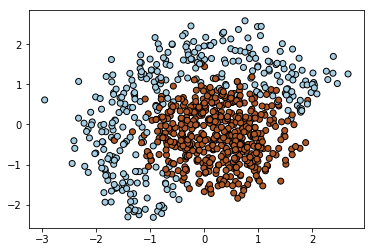

In [73]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = (y==1) | (X[:,1] > X[:,0] - 0.5)

X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
plt.show()

X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [74]:
import numpy as np

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):    
    plt.clf()
    xy = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Z = classify(xy, w).cpu()
    
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [76]:
def expand(X):
    X = X.cuda()
    prod = X[:,0] * X[:,1]
    prod = prod.unsqueeze(1)
    oness = torch.ones_like(X[:, 0]).cuda()
    oness = oness.unsqueeze(1)
    res = torch.cat([X, X ** 2, prod, oness], dim=1)
    return res

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    return torch.sign(torch.mv(expand(X), w.cuda()))

The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [79]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    single_loss = torch.ones_like(X[:, 0]).cuda() - y.cuda().float() * torch.mv(expand(X), w.cuda())
    concatenated = torch.cat([single_loss.unsqueeze(1), torch.zeros_like(single_loss).cuda().unsqueeze(1)], dim=1)
    maxes = torch.max(concatenated, dim=1, out=None)[0]
    return torch.sum(maxes) / len(X)


def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    """
    X = expand(X)
    yX = y.cuda().float().unsqueeze(1) * X
    single_loss = torch.ones_like(X[:, 0]) - torch.mv(yX, w.cuda())
    concatenated = torch.cat([torch.zeros_like(single_loss).cuda().unsqueeze(1), single_loss.unsqueeze(1)], dim=1)
    maxes = torch.max(concatenated, dim=1)[1]

    # Cheat?
    real_grad = torch.sum(-maxes.float().unsqueeze(1) * yX, dim=0) / len(X)
    return real_grad


### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

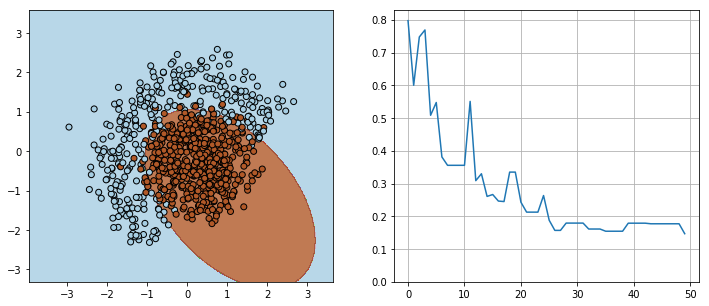

Best alpha: 0.7500000000000002
Loss: 0.1468302607536316
Weights: [ 1.3817985 -1.5007678 -1.2641221 -1.1095594 -1.1057298  2.8125   ]


In [89]:
n_iter = 50
batch_size = 4

alphas = np.arange(0.05, 0.8, 0.025)
best_alpha = 0.05
best_loss = 1.
best_loss_plot = np.ones(n_iter)
best_w = torch.Tensor([1, 0, 0, 0, 0, 0])

plt.figure(figsize=(12,5))

for alpha in alphas:
    random.seed(seed)
    w = torch.Tensor([1, 0, 0, 0, 0, 0])
    loss = np.zeros(n_iter)
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        if loss[i] < best_loss:
            best_alpha = alpha
            best_loss = loss[i]
            best_loss_plot = loss
            best_w = w
        visualize(X[ind,:], y[ind], w, loss, n_iter)
        w = w - alpha * compute_grad(X[ind,:], y[ind], w)

visualize(X, y, best_w, best_loss_plot, n_iter)
plt.clf()
print("Best alpha:", best_alpha)
print("Loss:", best_loss)
print("Weights:", np.array(best_w))

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

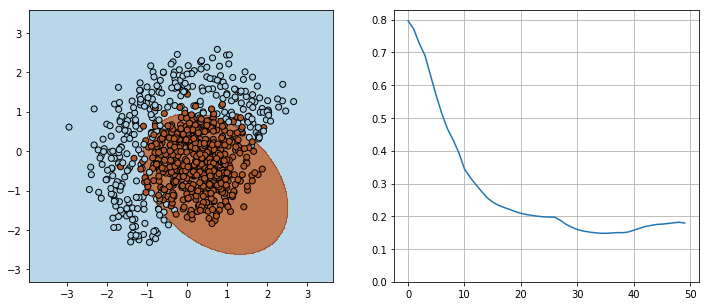

Best alpha: 0.61
Best mu: 0.89
Loss: 0.14803551137447357
Weights: [ 1.0059594  -1.4822325  -1.2030599  -1.2384821  -0.82394725  2.5491307 ]


In [90]:
n_iter = 50
batch_size = 4

alphas = np.arange(0.59, 0.7, 0.01)
mus = np.arange(0.83, 0.93, 0.01)

best_alpha = 0.
best_mu = 0.
best_loss = 1.
best_loss_plot = np.ones(n_iter)
best_w = torch.Tensor([1, 0, 0, 0, 0, 0])

plt.figure(figsize=(12,5))

for alpha in alphas:
    for mu in mus:
        random.seed(seed)
        w = torch.Tensor([1, 0, 0, 0, 0, 0])
        v = torch.zeros_like(w)
        loss = np.zeros(n_iter)
        for i in range(n_iter):
            ind = random.sample(range(X.shape[0]), batch_size)
            loss[i] = compute_loss(X, y, w)
            
            if loss[i] < best_loss:
                best_alpha = alpha
                best_mu = mu
                best_loss = loss[i]
                best_loss_plot = loss
                best_w = w
            
            visualize(X[ind,:], y[ind], w, loss, n_iter)

            v = mu * v + (1 - mu) * compute_grad(X[ind,:], y[ind], w)
            w = w - alpha * v

visualize(X, y, best_w, best_loss_plot, n_iter)
plt.clf()
print("Best alpha:", best_alpha)
print("Best mu:", best_mu)
print("Loss:", best_loss)
print("Weights:", np.array(best_w))

Same task but for Nesterov's accelerated gradient:

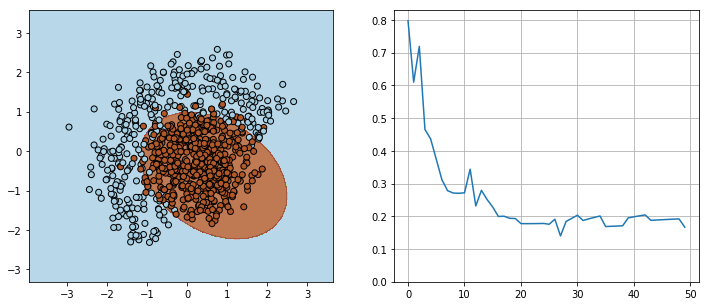

Best alpha: 0.6100000000000001
Best mu: 0.89
Loss: 0.1401176154613495
Weights: [ 1.1709325 -1.5052598 -1.3354983 -1.7307515 -0.9756973  3.147359 ]


In [83]:
n_iter = 50
batch_size = 4

alphas = np.arange(0.55, 0.76, 0.01)
mus = np.arange(0.88, 0.96, 0.01)

plt.figure(figsize=(12,5))

best_alpha = 0.
best_mu = 0.
best_loss = 1.
best_loss_plot = np.ones(n_iter)
best_w = torch.Tensor([1, 0, 0, 0, 0, 0])

for alpha in alphas:
    for mu in mus:
        random.seed(seed)
        v = torch.zeros_like(w)
        w = torch.Tensor([1, 0, 0, 0, 0, 0])
        loss = np.zeros(n_iter)
        for i in range(n_iter):
            ind = random.sample(range(X.shape[0]), batch_size)
            loss[i] = compute_loss(X, y, w)
            
            if loss[i] < best_loss:
                best_alpha = alpha
                best_mu = mu
                best_loss = loss[i]
                best_loss_plot = loss
                best_w = w
            
            visualize(X[ind,:], y[ind], w, loss, n_iter)
            
            v = mu * v + (1 - mu) * compute_grad(X[ind,:], y[ind], w)
            w = w - alpha * v
            w = w - alpha * compute_grad(X[ind, :], y[ind], w)
        plt.clf()

visualize(X, y, best_w, best_loss_plot, n_iter)
plt.clf()
print("Best alpha:", best_alpha)
print("Best mu:", best_mu)
print("Loss:", best_loss)
print("Weights:", np.array(best_w))

Finally, try Adam algorithm. You can start with beta = 0.9 and mu = 0.999

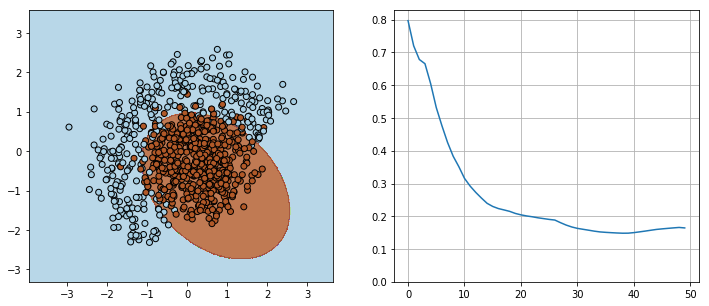

Best alpha: 0.025
Loss: 0.14831282198429108
Weights: [ 1.011221  -1.5430602 -1.2174965 -1.2101309 -0.8323747  2.6201386]


In [88]:
n_iter = 50
batch_size = 4

alphas = np.arange(0.005, 0.15, 0.001)
beta = 0.9
mu = 0.999
eps = 1e-6

best_alpha = 0.
best_loss = 1.
best_loss_plot = np.ones(n_iter)
best_w = torch.Tensor([1, 0, 0, 0, 0, 0])

plt.figure(figsize=(12,5))

for alpha in alphas:
    random.seed(seed)
    w = torch.Tensor([1, 0, 0, 0, 0, 0])
    v = torch.zeros_like(w)
    c = torch.zeros_like(w)
    g = torch.zeros_like(w)

    loss = np.zeros(n_iter)
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        visualize(X[ind,:], y[ind], w, loss, n_iter)
        
        if loss[i] < best_loss:
            best_alpha = alpha
            best_loss = loss[i]
            best_loss_plot = loss
            best_w = w

        grad = compute_grad(X[ind,:], y[ind], w).cpu()
        v = beta * v + (1 - beta) * grad
        c = mu * c + (1 - mu) * grad**2
        w = w - alpha / (c ** 0.5 + eps) * v

visualize(X, y, best_w, best_loss_plot, n_iter)
plt.clf()
print("Best alpha:", best_alpha)
print("Loss:", best_loss)
print("Weights:", np.array(best_w))